In [9]:
# Make BAMS time-series plot of Ft. Myers data from Ap
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string

%run -i scat_stats.py

In [2]:
# make a list of all of the time-series
data_dir = "F:/crs/proj/2025_NOPP_comparison/Ian_figure/"
flist = glob.glob(data_dir+'*.csv')
print(len(flist))
print(flist)

24
['F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8723970.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8724580.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8725110.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8725520.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726384.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726520.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726607.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726674.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8726724.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8727520.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8728690.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8729108.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8729210.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8729840.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8732828.csv', 'F:/crs/proj/2025_NOPP_comparison/Ian_figure\\8735180.csv', 'F:/crs/proj/2025_NOPP_comparison/Ia

In [3]:
# Ft Meyers is 8725520
fn = '8725520.csv'
df = pd.read_csv(data_dir+fn)
print(df)

                    time     obs    pred       mod
0    2022-09-27 00:00:00  0.4625  0.1645  0.343610
1    2022-09-27 00:10:00  0.4505  0.1515  0.333432
2    2022-09-27 00:20:00  0.4440  0.1420  0.323165
3    2022-09-27 00:30:00  0.4320  0.1330  0.313652
4    2022-09-27 00:40:00  0.4205  0.1210  0.303522
..                   ...     ...     ...       ...
428  2022-09-29 23:20:00  0.4580  0.1570  0.808853
429  2022-09-29 23:30:00  0.4520  0.1585  0.804642
430  2022-09-29 23:40:00  0.4475  0.1590  0.800205
431  2022-09-29 23:50:00  0.4410  0.1590  0.795485
432  2022-09-30 00:00:00  0.4400  0.1580  0.790627

[433 rows x 4 columns]


In [12]:
print(df.dtypes)
df["time"] = pd.to_datetime(df["time"])
print(df.dtypes)
# Compute delta_t in seconds
delta_t = (df["time"].diff().dropna().dt.total_seconds()).iloc[0]

print('Delta_t: ', delta_t)
# Find peak timing and value for "obs"
obs_peak_idx = df["obs"].idxmax()  # Index of max value
obs_peak_time = df.loc[obs_peak_idx, "time"]  # Corresponding time
obs_peak_value = df.loc[obs_peak_idx, "obs"]  # Peak value

# Find peak timing and value for "pred"
pred_peak_idx = df["pred"].idxmax()
pred_peak_time = df.loc[pred_peak_idx, "time"]
pred_peak_value = df.loc[pred_peak_idx, "pred"]

# Find peak timing and value for "mod"
mod_peak_idx = df["mod"].idxmax()
mod_peak_time = df.loc[mod_peak_idx, "time"]
mod_peak_value = df.loc[mod_peak_idx, "mod"]
ts0 = "Ft. Meyers 8725520"
ts1 = "Obs peak: {:.2f} m at {}".format(obs_peak_value, obs_peak_time.strftime('%H:%M'))
ts2 = "Mod peak: {:.2f} m at {}".format(mod_peak_value, mod_peak_time.strftime('%H:%M'))

S = df["mod"].values
O = df["obs"].values

# Find cross-correlations
zero_lag_corr, max_corr, max_lag, ts3 = calc_lag_corr( S, O, delta_t, verbose=True)

# Bias, RMSE, and NRMSE
bias = calc_bias( S, O, verbose=True )
rmsd = calc_RMSE( S, O )
nrmsd = calc_NRMSE( S, O )
mad = calc_MAD( S, O )
ts4 = "Bias:  {:.2f} m\nMAD: {:.3f} m\nRMSD:  {:.3f} m\nNRMSD: {:.3f}".format( bias, mad, rmsd, nrmsd )
wss = calc_WSS( df["mod"].values, df["obs"].values )
ts5 = 'WSS: {:.3f}'.format( wss )

print(ts0)
print(ts1)
print(ts2)
print(ts3)
print(ts4)
print(ts5)


# Big text string
tsb = ts0="\n"+ts1+"\n"+ts2+"\n"+ts3+"\n"+ts4+"\n"+ts5

time    datetime64[ns]
obs            float64
pred           float64
mod            float64
dtype: object
time    datetime64[ns]
obs            float64
pred           float64
mod            float64
dtype: object
Delta_t:  600.0
Pos. lag indicates model is earlier.
Zero-lag Correlation: 0.967
Max Correlation: 0.974 at Lag = -4 time steps
Bias: 0.0331 Positive means model is higher.
Ft. Meyers 8725520
Obs peak: 2.41 m at 22:10
Mod peak: 2.39 m at 22:50
Corr at lag( 0 ): 0.967
Max corr: 0.974 at lag( -2400 s )
Bias:  0.03 m
MAD: 0.204 m
RMSD:  0.246 m
NRMSD: 0.268
WSS: 0.875


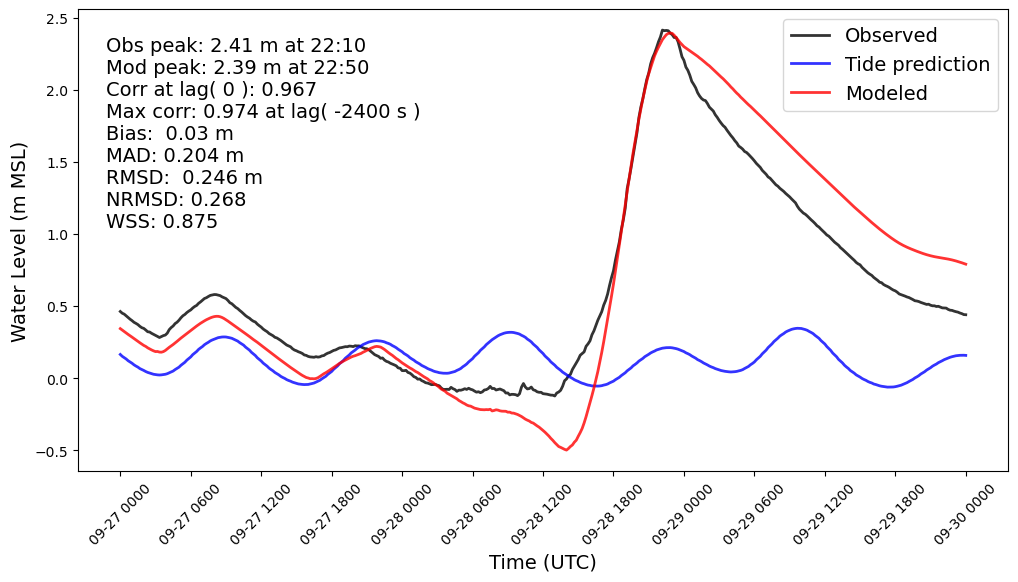

In [14]:
# Plot all three time series

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.plot(df["time"], df["obs"], label="Observed", color="k", alpha=.8, linewidth=2)
plt.plot(df["time"], df["pred"], label="Tide prediction", alpha=.8, color="b", linewidth=2)
plt.plot(df["time"], df["mod"], label="Modeled", color="r", alpha=.8, linewidth=2)

# Set time axis to label every 6 hours
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H%M"))

# Improve readability
plt.xticks(rotation=45)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("Water Level (m MSL)", fontsize=14)
plt.legend( fontsize=14)
plt.text(.03,.99, tsb, ha='left', va='top', transform=ax.transAxes, fontsize=14)
figdir = 'F:/crs/proj/2025_NOPP_comparison/BAMS_figure/'
plt.savefig(figdir+'BAMS_Ft_Meyers_time_series.png', dpi=200, bbox_inches='tight')
plt.savefig(figdir+'BAMS_Ft_Meyers_time_series.svg', dpi=200, bbox_inches='tight')